In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
import os
import cv2
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy


def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

   
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        print("Using GPU")
        image = image.cuda()
        net = net.cuda()
    else:
        print("Using CPU")


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            # x.zero_grad()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image



def Resnet50(im1):
  net = models.resnet50(pretrained=True)

  # Switch to evaluation mode
  net.eval()

  mean = []
  std = []



  for i in range(3):
    mean.append(im1[:,:,i].mean() / 255)
    std.append(im1[:,:,i].std() / 255)

  im_orig = Image.fromarray(np.uint8(im1)).convert('RGB')

  # print(std , mean)



  # Remove the mean
  im = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean,
                          std = std)])(im_orig)

  r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)

  pert_image1 = np.dstack(( pert_image.cpu().data[0,0].numpy(), pert_image.cpu().data[0,1].numpy(), pert_image.cpu().data[0,2].numpy()))  


  labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

  str_label_orig = labels[np.int(label_orig)].split(',')[0]
  str_label_pert = labels[np.int(label_pert)].split(',')[0]

  print("Original label = ", str_label_orig)
  print("Perturbed label = ", str_label_pert)

  def clip_tensor(A, minv, maxv):
      A = torch.max(A, minv*torch.ones(A.shape))
      A = torch.min(A, maxv*torch.ones(A.shape))
      return A

  clip = lambda x: clip_tensor(x, 0, 255)

  tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=map(lambda x: 1 / x, std)),
                          transforms.Normalize(mean=map(lambda x: -x, mean), std=[1, 1, 1]),
                          transforms.Lambda(clip),
                          transforms.ToPILImage(),
                          transforms.CenterCrop(224)])

  return pert_image1



imgs = []

imgs.append(cv2.imread('1.jpg'))
imgs.append(cv2.imread('2.jpg'))
imgs.append(cv2.imread('3.jpg'))

pert_imgs = []
for img in imgs:
  pert_imgs.append(Resnet50(img))
 

ModuleNotFoundError: No module named 'torch'

Using GPU


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Original label =  n02514041 barracouta
Perturbed label =  n03935335 piggy bank
Using GPU
Original label =  n01667778 terrapin
Perturbed label =  n04456115 torch
Using GPU
Original label =  n07714990 broccoli
Perturbed label =  n07714990 broccoli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


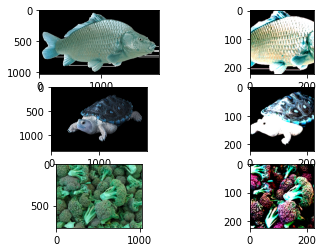

In [ ]:
f, axarr = plt.subplots(3,2)
for i in range(3):
  axarr[i,0].imshow(imgs[i])
  axarr[i,1].imshow(pert_imgs[i])


In [ ]:
pert_imgs[0].shape

(224, 224, 3)